In [1]:
import pandas as pd
df = pd.read_excel(r'C:\Users\Edu\Desktop\Definitivo.xlsx', 'ru_ln3', header = 1).set_index('Date')
df

,Ex_rate,IR,FCR,CPI,M1,WTI
Date,,,,,,
1994-07-01,-150.595023,NaN,NaN,-53.329848,NaN,NaN
1994-08-01,-108.518349,NaN,NaN,-96.162427,NaN,NaN
1994-09-01,-80.282655,NaN,NaN,-126.035314,NaN,NaN
1994-10-01,-72.874658,NaN,NaN,-151.691454,NaN,NaN
1994-11-01,-14.569628,NaN,NaN,-123.773967,NaN,NaN
...,...,...,...,...,...,...
2020-04-01,6.036656,7.634289,3.755986,-1.978434,13.585103,-64.743975
2020-05-01,8.958779,5.267345,0.482604,-2.019192,17.822579,-65.670429
2020-06-01,2.608156,-3.356208,-5.482385,-1.409535,19.490853,-53.535747


In [2]:
df = df.drop(['CPI','IR','FCR'], axis=1)
df = df.dropna()

df

,Ex_rate,M1,WTI
Date,,,
2002-12-01,-0.665002,23.074769,-60.651449
2003-01-01,-1.482825,25.490415,-41.725177
2003-02-01,-4.026264,28.123920,-16.507781
2003-03-01,-5.772061,31.058535,16.760988
2003-04-01,-7.118617,32.385516,46.391634
...,...,...,...
2020-03-01,-13.938980,11.595953,-42.392045
2020-04-01,6.036656,13.585103,-64.743975
2020-05-01,8.958779,17.822579,-65.670429


In [8]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)

(208, 3)
(4, 3)


In [9]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
        
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Ex_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9364
 No. Lags Chosen       = 14
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0018. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "M1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5188
 No. Lags Chosen       = 13
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0075. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "WTI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

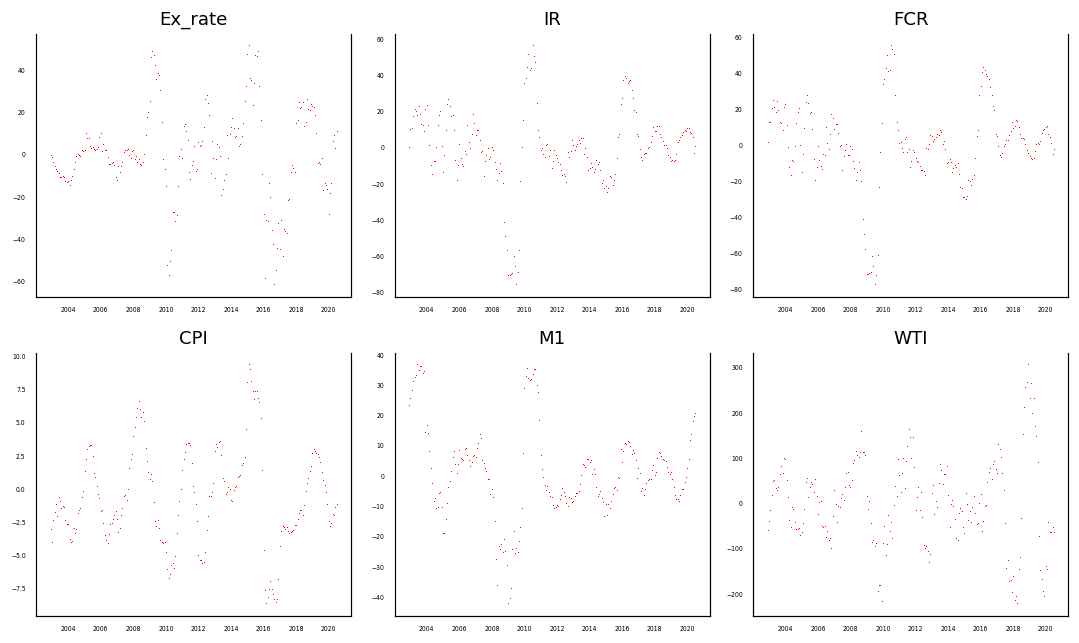

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=109, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]] #Esto es para que los títulos tengan los mismos nombres que los cabezales
    ax.plot(data, ',', color='red', linewidth=99)
 # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=4)
    
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
#6. Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=14
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
    
grangers_causation_matrix(df, variables = df.columns)

,Ex_rate_x,M1_x,WTI_x
Ex_rate_y,1.0000,0.0030,0.017
M1_y,0.4190,1.0000,0.000
WTI_y,0.3482,0.0002,1.000


In [4]:
#Es muy interesante esto que hemos encontrado de las endógenas y exógenas
#Tal vez deberiamos incluir WTI en el grupo de endógenas
#saber como se pone la frecuencia queda pendiente
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
model = VAR(endog=df[['Ex_rate','WTI']],exog=df[['M1','WTI']],freq=None)

C:\Users\Edu\anaconda3\envs\geo_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [5]:
#fit([maxlags, method, ic, trend, verbose])
results = model.fit(maxlags=5,method='GLS',ic='hqic',trend='nc',verbose=True)
results.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 3, FPE -> 3, HQIC -> 3>
Using 3 based on hqic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 16, Oct, 2020
Time:                     12:08:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -56.3053
Nobs:                     209.000    HQIC:                  -56.4577
Log likelihood:           5333.52    FPE:                2.72795e-25
AIC:                     -56.5612    Det(Omega_mle):     2.53052e-25
--------------------------------------------------------------------
Results for equation Ex_rate
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
M1                -0.123235         0.046929           -2.626           0.009
WTI               -0.008932         0.013756           -0.649           0.516
L1.Ex_rate         0.994112         0.068471           14.519         

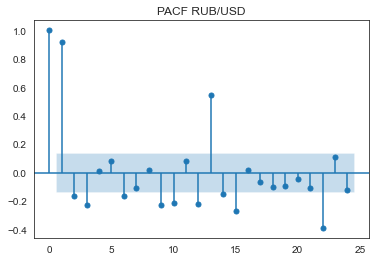

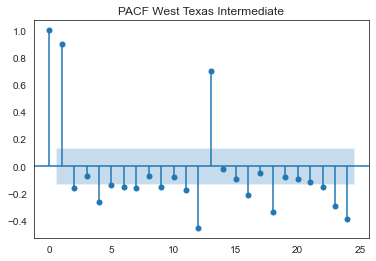

In [7]:
import seaborn
import matplotlib.pyplot as plt
seaborn.set_style("white")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df['Ex_rate'],title='PACF RUB/USD')
plot_pacf(df['WTI'],title='PACF West Texas Intermediate')
plt.show()

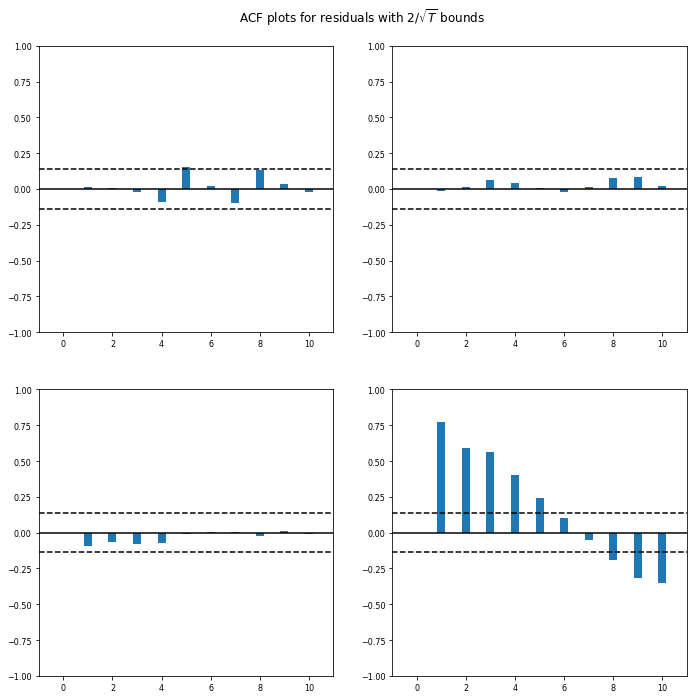

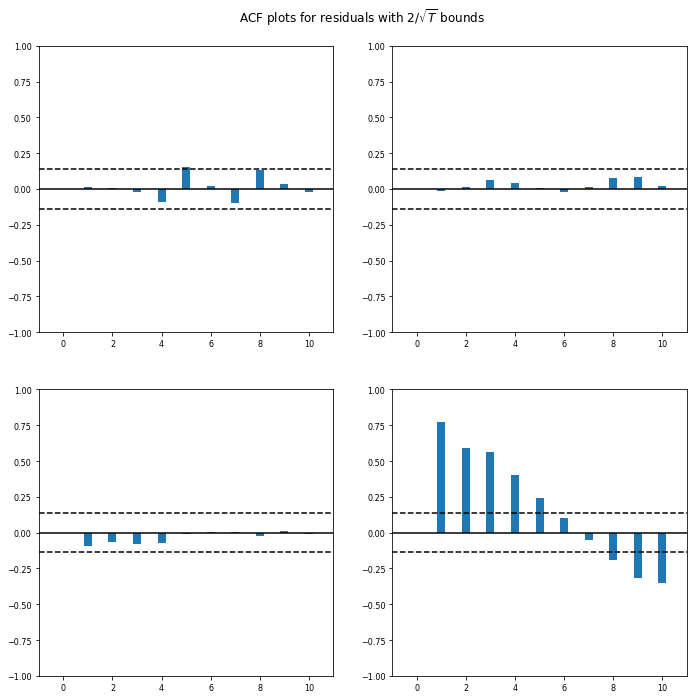

In [9]:
results.plot_acorr()

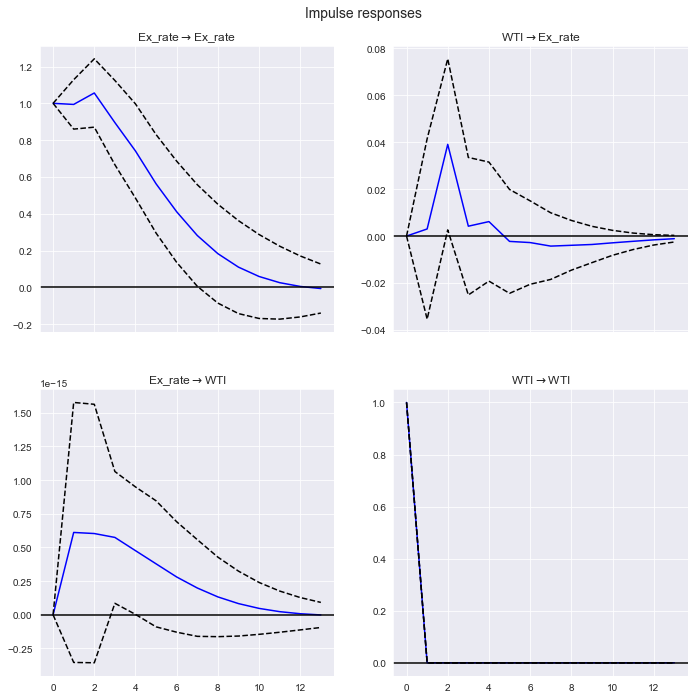

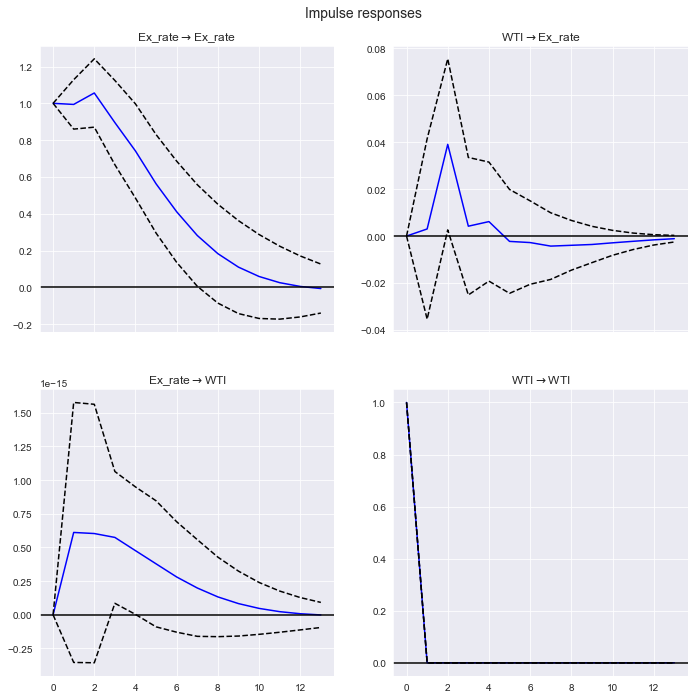

In [55]:
import seaborn
seaborn.set_style("darkgrid")
irf = results.irf(13)
irf.plot(orth=False)

In [40]:
stability = results.is_stable(verbose=bool)
stability

Eigenvalues of VAR(1) rep
0.726526410003054
0.726526410003054
0.4210248838991268
8.884406413673462e-06
8.884403755601664e-06
8.884403755601664e-06


True

In [41]:
autocorrelation = results.resid_acorr(nlags=5)
autocorrelation

array([[[ 1.        , -0.00380274],
        [-0.00380274,  1.        ]],

       [[ 0.01211992, -0.01103008],
        [-0.09061887,  0.77338745]],

       [[ 0.0052792 ,  0.01487702],
        [-0.06556436,  0.58904677]],

       [[-0.01836477,  0.06237496],
        [-0.07624252,  0.56175989]],

       [[-0.09275289,  0.04214492],
        [-0.07286111,  0.40450039]],

       [[ 0.1559527 ,  0.0048289 ],
        [-0.01277163,  0.2408067 ]]])

In [42]:
#H0 (null) : data are generated by a Gaussian-distributed process [Jarque-Bera-style]
normality = results.test_normality(signif=0.10)
normality.summary()

Test statistic,Critical value,p-value,df
53.83,7.779,0.000,4


In [11]:
autocorr2 = results.test_whiteness(nlags=12, signif=0.05, adjusted=True)
autocorr2.summary()

Test statistic,Critical value,p-value,df
599.1,51.00,0.000,36
